<a href="https://colab.research.google.com/github/DIFACQUIM/De-Novo_DNMT1/blob/main/01_Data_curation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code based on:
https://github.com/DIFACQUIM/Food_chemicals_characterization/blob/main/codes/data_curation_copy.ipynb <br>
Sánchez-Cruz N, Pilón-Jiménez BA and Medina-Franco JL. Functional group and diversity analysis of BIOFACQUIM: A Mexican natural product database. F1000Research 2020, 8(Chem Inf Sci):2071 DOI:[10.12688/f1000research.21540](https://f1000research.com/articles/8-2071/v2).

In [ ]:
!pip install rdkit

In [ ]:
!pip install molvs

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from molvs.standardize import Standardizer
from molvs.charge import Uncharger, Reionizer
from molvs.fragment import LargestFragmentChooser
from molvs.tautomer import TautomerCanonicalizer
from rdkit.Chem.rdmolops import GetFormalCharge, RemoveStereochemistry

In [ ]:
#Read original data
data=pd.read_csv("/content/LigBuilder-UNPDA.csv", delimiter=',')
data.head(2)

,SMILES,DATABASE,ID,PROGRAM,FRAGMENTS,DATASET,PROGRAM_SCORE
0,C1(=C(N/C(=[NH]/C/C=C(\CCC2=CC=C(C(=O)O)O2)/C(...,LB_UNPDA,LBUNP01_001,LigBuilder,Natural Products,LB_UNPDA01,6.89
1,C1(=C(N/C(=[NH]/C/C=C(\CCC2=CC=C(C(=O)O)O2)/C(...,LB_UNPDA,LBUNP01_002,LigBuilder,Natural Products,LB_UNPDA01,6.89


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SMILES         1091 non-null   object 
 1   DATABASE       1091 non-null   object 
 2   ID             1091 non-null   object 
 3   PROGRAM        1091 non-null   object 
 4   FRAGMENTS      1091 non-null   object 
 5   DATASET        1091 non-null   object 
 6   PROGRAM_SCORE  1091 non-null   float64
dtypes: float64(1), object(6)
memory usage: 59.8+ KB


In [ ]:
#Delete rows without SMILES
print(data.shape)
data.dropna(subset=["SMILES"])
print(data.shape)

(1091, 7)
(1091, 7)


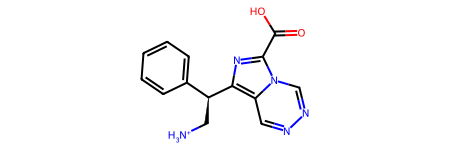

In [ ]:
smi = list(data["SMILES"])[25]
smi
from rdkit.Chem.Draw import IPythonConsole
Chem.MolFromSmiles(smi)

In [ ]:
#Descending order for program scores
data.sort_values('PROGRAM_SCORE', ascending=False, inplace=True, ignore_index=True)
data

,SMILES,DATABASE,ID,PROGRAM,FRAGMENTS,DATASET,PROGRAM_SCORE
0,C1(=N[N]/C(=[NH]\[C@@H](C#CCNCCN)C2=CNC(=C2CCO...,LB_UNPDA,LBUNP09_716,LigBuilder,Natural Products,LB_UNPDA09,8.53
1,C1(=N[N]/C(=[NH]\[C@@H](C#CCCN)C2=CNC(=C2CN)C(...,LB_UNPDA,LBUNP09_501,LigBuilder,Natural Products,LB_UNPDA09,8.26
2,C1(=N[N]/C(=[NH]\[C@@H](C#CCCN)C2=CNC(=C2CN)C(...,LB_UNPDA,LBUNP09_544,LigBuilder,Natural Products,LB_UNPDA09,8.26
3,C1(=N[N]/C(=[NH]\[C@@H](C#CC(=O)OC)C2=CNC(=C2)...,LB_UNPDA,LBUNP09_205,LigBuilder,Natural Products,LB_UNPDA09,8.06
4,C1(=N[N]/C(=[NH]\[C@@H](C#CCCO)C2=CNC(=C2CN)C(...,LB_UNPDA,LBUNP09_685,LigBuilder,Natural Products,LB_UNPDA09,8.04
...,...,...,...,...,...,...,...
1086,C(=O)(O)c1cc(cc(c1)C(=O)O)[C@H](N)OCc1cc(c(nc1...,LB_UNPDA,LBUNP02_037,LigBuilder,Natural Products,LB_UNPDA02,6.40
1087,C(=O)(O)c1cc(cc(c1)C(=O)O)[C@H](N)OCc1cc(c(nc1...,LB_UNPDA,LBUNP02_038,LigBuilder,Natural Products,LB_UNPDA02,6.40
1088,C(=O)(O)c1cc(cc(c1)C(=O)O)[C@H](N)OCc1cc(c(nc1...,LB_UNPDA,LBUNP02_039,LigBuilder,Natural Products,LB_UNPDA02,6.40
1089,C(=O)(O)c1cc(cc(c1)C(=O)O)[C@H](N)OCc1cc(c(nc1...,LB_UNPDA,LBUNP02_040,LigBuilder,Natural Products,LB_UNPDA02,6.40


In [ ]:
# Define functions
STD = Standardizer() # Get the standardized version of a given SMILES string (canonical SMILES).
LFC = LargestFragmentChooser() # Select the largest fragment from a salt (ionic compound).
UC = Uncharger() # Charge corrections are applied to ensure, for example, that free metals are correctly ionized.
RI = Reionizer() # Neutralize molecule by adding/removing hydrogens.
TC = TautomerCanonicalizer()  # Return a tautormer “reasonable” from a chemist’s point, but isn’t guaranteed to be the most energetically favourable.

In [ ]:
def MasterStandarization_no_chiral(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol == None:
            #If rdkit could not parse the smiles, returns Error 1
            return "Error 1"
        else:
            mol = STD(mol)
            mol = LFC(mol)

            allowed_elements = {"H","B","C","N","O","F","Si","P","S","Cl","Se","Br","I"}
            actual_elements = set([atom.GetSymbol() for atom in mol.GetAtoms()])
            if len(actual_elements-allowed_elements) == 0:
                mol = UC(mol)
                mol = RI(mol)
                RemoveStereochemistry(mol)
                mol = TC(mol)
                return Chem.MolToSmiles(mol)
            else:
                # If molecule contains other than the allowed elements, return "Error 2"
                return "Error 2"
    except:
        return "Something else was found"

In [ ]:
def MasterStandarization_chiral(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol == None:
            #If rdkit could not parse the smiles, returns Error 1
            return "Error 1"
        else:
            mol = STD(mol)
            mol = LFC(mol)

            allowed_elements = {"H","B","C","N","O","F","Si","P","S","Cl","Se","Br","I"}
            actual_elements = set([atom.GetSymbol() for atom in mol.GetAtoms()])
            if len(actual_elements-allowed_elements) == 0:
                mol = UC(mol)
                mol = RI(mol)
                #RemoveStereochemistry(mol)
                mol = TC(mol)
                return Chem.MolToSmiles(mol)
            else:
                # If molecule contains other than the allowed elements, return "Error 2"
                return "Error 2"
    except:
        return "Something else was found"

In [ ]:
#New SMILES preserving chiral information
data["SMILES_chiral"] = [MasterStandarization_chiral(x) for x in data["SMILES"]]

[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:51:49] Explicit valence for atom # 4 N, 4, is g

In [ ]:
#New SMILES without chiral information
data["SMILES_no_chiral"] = [MasterStandarization_no_chiral(x) for x in data["SMILES"]]
data.shape

[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is greater than permitted
[20:57:47] Explicit valence for atom # 4 N, 4, is g

(1091, 9)

In [ ]:
len(data[data["SMILES_chiral"] == "Something else was found"])

0

In [ ]:
len(data[data["SMILES_no_chiral"] == "Something else was found"])

0

In [ ]:
# Delete smiles that rdkit could not read
data= data[data["SMILES_chiral"] != "Error 1"]
print(data.shape)
# Delete smiles that no contain allowed atoms
data = data[data["SMILES_chiral"] != "Error 2"]
print(data.shape)
# Delete other errors
data = data[data["SMILES_chiral"] != "Something else was found"].reset_index(drop=True)
print(data.shape)

(308, 9)
(308, 9)
(308, 9)


In [ ]:
# Delete smiles that rdkit could not read
data= data[data["SMILES_no_chiral"] != "Error 1"]
print(data.shape)
# Delete smiles that no contain allowed atoms
data = data[data["SMILES_no_chiral"] != "Error 2"]
print(data.shape)
# Delete other errors
data = data[data["SMILES_no_chiral"] != "Something else was found"].reset_index(drop=True)
print(data.shape)

(308, 9)
(308, 9)
(308, 9)


In [ ]:
data.head(2)

,SMILES,DATABASE,ID,PROGRAM,FRAGMENTS,DATASET,PROGRAM_SCORE,SMILES_chiral,SMILES_no_chiral
0,C(=O)(O)c1ccc(c(c1)C(=O)O)/C(=C\c1ccc(cc1)Br)/...,LB_UNPDA,LBUNP02_078,LigBuilder,Natural Products,LB_UNPDA02,7.81,O=C(O)c1ccc(/C(=C\c2ccc(Br)cc2)C(O)c2ncon2)c(C...,O=C(O)c1ccc(C(=Cc2ccc(Br)cc2)C(O)c2ncon2)c(C(=...
1,Ic1cc(ncc1O)C(=C)CNCCN[C@@H](C(=O)O)c1ncc2c(n1...,LB_UNPDA,LBUNP05_020,LigBuilder,Natural Products,LB_UNPDA05,7.41,CC(C=NCCNC(C(=O)O)c1ncc2c(ncn2CC(=O)O)n1)c1cc(...,CC(C=NCCNC(C(=O)O)c1ncc2c(ncn2CC(=O)O)n1)c1cc(...


In [ ]:
# Delete duplicates
data = data.drop_duplicates(subset=["SMILES_chiral"], keep="first").reset_index(drop=True)
print(data.shape)
data.head(10)

(117, 9)


,SMILES,DATABASE,ID,PROGRAM,FRAGMENTS,DATASET,PROGRAM_SCORE,SMILES_chiral,SMILES_no_chiral
0,C(=O)(O)c1ccc(c(c1)C(=O)O)/C(=C\c1ccc(cc1)Br)/...,LB_UNPDA,LBUNP02_078,LigBuilder,Natural Products,LB_UNPDA02,7.81,O=C(O)c1ccc(/C(=C\c2ccc(Br)cc2)C(O)c2ncon2)c(C...,O=C(O)c1ccc(C(=Cc2ccc(Br)cc2)C(O)c2ncon2)c(C(=...
1,Ic1cc(ncc1O)C(=C)CNCCN[C@@H](C(=O)O)c1ncc2c(n1...,LB_UNPDA,LBUNP05_020,LigBuilder,Natural Products,LB_UNPDA05,7.41,CC(C=NCCNC(C(=O)O)c1ncc2c(ncn2CC(=O)O)n1)c1cc(...,CC(C=NCCNC(C(=O)O)c1ncc2c(ncn2CC(=O)O)n1)c1cc(...
2,C1=C(N(N=C1COC(=O)C1=COC=C1C(=O)O)C(=O)N(CI)c1...,LB_UNPDA,LBUNP09_262,LigBuilder,Natural Products,LB_UNPDA09,7.29,CCCCc1c(OC[C@@H](N)CN)cccc1N(CI)C(=O)n1[nH]c(C...,CCCCc1c(OCC(N)CN)cccc1N(CI)C(=O)n1[nH]c(COC(=O...
3,C(=O)(O)c1c(cc(cn1)C[C@H](NCCN)C1=C(NN=N1)C(=O...,LB_UNPDA,LBUNP02_176,LigBuilder,Natural Products,LB_UNPDA02,7.26,NCC=NC(Cc1cnc(C(=O)O)c(C(=O)O)c1)c1[nH]nnc1C(=...,NCC=NC(Cc1cnc(C(=O)O)c(C(=O)O)c1)c1[nH]nnc1C(=...
4,C1=C(N(N=C1COC(=O)C1=COC=C1C(=O)O)C(=O)N(CI)c1...,LB_UNPDA,LBUNP09_142,LigBuilder,Natural Products,LB_UNPDA09,7.22,NC[C@H](N)COc1cccc(N(CI)C(=O)n2[nH]c(COC(=O)c3...,NCC(N)COc1cccc(N(CI)C(=O)n2[nH]c(COC(=O)c3cocc...
5,Ic1cc(ncc1O)/C(=C/c1ccc(cc1)O)/CNCCN[C@@H](C(=...,LB_UNPDA,LBUNP05_027,LigBuilder,Natural Products,LB_UNPDA05,7.21,O=C(O)C(NCCN=CC(Cc1ccc(O)cc1)c1cc(I)c(O)cn1)c1...,O=C(O)C(NCCN=CC(Cc1ccc(O)cc1)c1cc(I)c(O)cn1)c1...
6,C(=O)(O)c1cc(cc(c1)C(=O)O)[C@H](N)OCc1cc(c(nc1...,LB_UNPDA,LBUNP02_114,LigBuilder,Natural Products,LB_UNPDA02,7.20,N=c1[nH]cc(CO[C@@H](N)c2cc(C(=O)O)cc(C(=O)O)c2...,N=c1[nH]cc(COC(N)c2cc(C(=O)O)cc(C(=O)O)c2)cc1CBr
7,Ic1cc(ncc1O)C1=NC=C(N1CF)CCC/C=C/CC(=O)O,LB_UNPDA,LBUNP05_040,LigBuilder,Natural Products,LB_UNPDA05,7.19,O=C(O)C=CCCCCc1cnc(-c2cc(I)c(O)cn2)n1CF,O=C(O)C=CCCCCc1cnc(-c2cc(I)c(O)cn2)n1CF
8,C1(=C(O[C@H](CC1=O)C(=O)Nc1ccc(cc1Cl)CN(CNCCI)...,LB_UNPDA,LBUNP04_016,LigBuilder,Natural Products,LB_UNPDA04,7.12,C=CC(=O)NCCCCN(CNCCI)Cc1ccc(NC(=O)c2cc(=O)c(CO...,C=CC(=O)NCCCCN(CNCCI)Cc1ccc(NC(=O)c2cc(=O)c(CO...
9,c1(c(cc2c(c1)N=CN2)C(=O)NC1=C(N(N=C1)CCC(=O)CC...,LB_UNPDA,LBUNP03_001,LigBuilder,Natural Products,LB_UNPDA03,7.11,O=C(CCO)CCn1ncc(NC(=O)c2cc3[nH]cnc3cc2C(=O)COC...,O=C(CCO)CCn1ncc(NC(=O)c2cc3[nH]cnc3cc2C(=O)COC...


In [ ]:
#Save database
data.to_csv("LigBuilder_UNPDA_chiral-curated.csv", sep=",", index=False)

In [ ]:
# Delete duplicates without chiral information
data = data.drop_duplicates(subset=["SMILES_no_chiral"], keep="first").reset_index(drop=True)
print(data.shape)
print(data.head(10))

(117, 9)
                                              SMILES  DATABASE           ID  \
0  C(=O)(O)c1ccc(c(c1)C(=O)O)/C(=C\c1ccc(cc1)Br)/...  LB_UNPDA  LBUNP02_078   
1  Ic1cc(ncc1O)C(=C)CNCCN[C@@H](C(=O)O)c1ncc2c(n1...  LB_UNPDA  LBUNP05_020   
2  C1=C(N(N=C1COC(=O)C1=COC=C1C(=O)O)C(=O)N(CI)c1...  LB_UNPDA  LBUNP09_262   
3  C(=O)(O)c1c(cc(cn1)C[C@H](NCCN)C1=C(NN=N1)C(=O...  LB_UNPDA  LBUNP02_176   
4  C1=C(N(N=C1COC(=O)C1=COC=C1C(=O)O)C(=O)N(CI)c1...  LB_UNPDA  LBUNP09_142   
5  Ic1cc(ncc1O)/C(=C/c1ccc(cc1)O)/CNCCN[C@@H](C(=...  LB_UNPDA  LBUNP05_027   
6  C(=O)(O)c1cc(cc(c1)C(=O)O)[C@H](N)OCc1cc(c(nc1...  LB_UNPDA  LBUNP02_114   
7           Ic1cc(ncc1O)C1=NC=C(N1CF)CCC/C=C/CC(=O)O  LB_UNPDA  LBUNP05_040   
8  C1(=C(O[C@H](CC1=O)C(=O)Nc1ccc(cc1Cl)CN(CNCCI)...  LB_UNPDA  LBUNP04_016   
9  c1(c(cc2c(c1)N=CN2)C(=O)NC1=C(N(N=C1)CCC(=O)CC...  LB_UNPDA  LBUNP03_001   

      PROGRAM         FRAGMENTS     DATASET  PROGRAM_SCORE  \
0  LigBuilder  Natural Products  LB_UNPDA02           7.81 